
# How to generate text: using different decoding methods for language generation with Transformers

adapted from: https://github.com/huggingface/blog/blob/main/notebooks/02_how_to_generate.ipynb

<a target="_blank" href="https://colab.research.google.com/github/haukelicht/advanced_text_analysis/blob/main/notebooks/incontext_learning/llm_text_generation_explained.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Introduction**

In recent years, there has been an increasing interest in open-ended language generation thanks to the rise of large transformer-based language models trained on millions of webpages, such as OpenAI's famous GPT models. 
Besides the improved transformer architecture and massive unsupervised training data, **better decoding methods** have also played an important role. 

This notebook gives a brief overview of different decoding strategies and more importantly shows how *you* can implement them with very little effort using the popular `transformers` library.


## Background

All of the following functionalities can be used for **auto-regressive** language generation ([here](http://jalammar.github.io/illustrated-gpt2/) a refresher). 

### Auto-regressive (causal) language generation

In short, *auto-regressive* language generation is based on the assumption that the probability distribution of a word sequence can be decomposed into the product of conditional next word distributions: 
$$ P(w_{1:T} | W_0 ) = \prod_{t=1}^T P(w_{t} | w_{1: t-1}, W_0) \text{ ,with }  w_{1: 0} = \emptyset, $$

and $W_0$ being the initial *context* word sequence. The length $T$ of the word sequence is usually determined *on-the-fly* and corresponds to the timestep $t=T$ the EOS token is generated from $P(w_{t} | w_{1: t-1}, W_{0})$.

### How to generate with a decoder model in `transformers`

We need to load the model with the `AutoModelForCausalLM`.

when loading from pre-trained model (using the `from_pretrained()` method) this method automatically loads the model in the *causal (i.e., auto-regressive) language modeling* mode:

In [47]:
import os
from transformers import AutoModelForCausalLM, AutoTokenizer, set_seed
os.environ["TRANSFORMERS_VERBOSITY"] = "error"

model_id = "Qwen/Qwen2.5-0.5B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id, pad_token_id=tokenizer.eos_token_id, device_map="auto")

To generate (i.e., choose the next token), we need to 

1. tokenize the current text sequence
2. pass the tokenized **inputs** to the model
3. decode the generated **outputs** back into text

In [53]:
# encode context the generation is conditioned on
inputs = tokenizer.encode('The sun is', return_tensors='pt')
inputs

tensor([[ 785, 7015,  374]])

The inputs are just a list of input token IDs per input text (i.e., one list per text, here N~text~=1)

because our model might be on another device than the CPU (e.g., a GPU), we need to move the input tensors to the same device as the model:

In [54]:
print(model.device)
# move the inputs tensor to the same device as the model
inputs = inputs.to(model.device)

mps:0


Now we can generate:

In [57]:
outputs = model.generate(inputs, max_new_tokens=1)
outputs

tensor([[ 785, 7015,  374, 7407]], device='mps:0')

Nice! The outputs are just the list of input token IDs per input text plus the generated token for each input text (here, N~text~=1).

Let's convert the token IDs into text:

In [59]:
# NOTE: we use detach() to avoid tracking this tensor in the computation graph
# and cpu() to move it to the CPU (from the GPU, if applicable) for
outputs.detach().cpu()

# NOTE: we use [0] to get the first (and only) sequence in the batch
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

The sun is located


## Sampling 

We will give a tour of the currently most prominent decoding methods, mainly *Greedy search*, *Beam search*, *Top-K sampling* and *Top-p sampling*.


Let's quickly install transformers and load the model. We will use GPT2 in Tensorflow 2.1 for demonstration, but the API is 1-to-1 the same for PyTorch.

### **Greedy Search**

Greedy search simply selects the word with the highest probability as its next word: $w_t = \text{argmax}_{w}P(w | w_{1:t-1})$ at each timestep $t$. The following sketch shows greedy search. 

![Greedy Search](https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/greedy_search.png){width="30%"}

Starting from the word $\text{"The"}$, the algorithm 
greedily chooses the next word of highest probability $\text{"nice"}$ and so on, so that the final generated word sequence is $\text{"The", "nice", "woman"}$ having an overall probability of $0.5 \times 0.4 = 0.2$.

In the following we will generate word sequences using GPT2 on the context $(\text{"I", "enjoy", "walking", "with", "my", "cute", "dog"})$. Let's see how greedy search can be used in `transformers` as follows:

In [12]:
# encode context the generation is conditioned on
input_ids = tokenizer.encode('I enjoy walking with my cute dog', return_tensors='pt')

# generate text until the output length (which includes the context length) reaches 20
set_seed(42)
greedy_output = model.generate(input_ids.to(model.device), max_length=100, do_sample=False)

print(tokenizer.decode(greedy_output[0].detach().cpu(), skip_special_tokens=True))

I enjoy walking with my cute dog, but I have a problem. My dog is very stubborn and refuses to let me walk her. What should I do?

It's understandable that you might feel frustrated or annoyed when your dog refuses to walk with you, especially if it's been a long time since they've walked together before. Here are some steps you can take to try to resolve the issue:

1. **Be Patient**: Sometimes dogs just need more time to understand what you're asking of them


Alright! We have generated our first short text with a generative LLM 😊. 

But one very common problem with greedy decoding in language generation is that words often start repeating (see [Vijayakumar et al., 2016](https://arxiv.org/abs/1610.02424) and [Shao et al., 2017](https://arxiv.org/abs/1701.03185)).

The **major drawback of greedy search**, however, is that it misses high probability words hidden behind a low probability word as can be seen in our sketch above:

The word $\text{"has"}$ with its high conditional probability of $0.9$ is hidden behind the word $\text{"dog"}$, which has only the second-highest conditional probability, so that greedy search misses the word sequence $\text{"The"}, \text{"dog"}, \text{"has"}$.

Thankfully, we have beam search to alleviate this problem!


### **Beam search**

Beam search reduces the risk of missing hidden high probability word sequences by keeping the most likely `num_beams` of hypotheses at each time step and eventually choosing the hypothesis that has the overall highest probability. Let's illustrate with `num_beams=2`:

![Beam search](https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/beam_search.png)

At time step $1$, besides the most likely hypothesis $\text{"The", "nice"}$, beam search also keeps track of the second most likely one $\text{"The", "dog"}$. At time step $2$, beam search finds that the word sequence $\text{"The", "dog", "has"}$ has with $0.36$ a higher probability than $\text{"The", "nice", "woman"}$, which has $0.2$. Great, it has found the most likely word sequence in our toy example! 

Beam search will always find an output sequence with higher probability than greedy search, but is not guaranteed to find the most likely output. 

Let's see how beam search can be used in `transformers`. We set `num_beams > 1` and `early_stopping=True` so that generation is finished when all beam hypotheses reached the EOS token.

In [14]:
# activate beam search and early_stopping
beam_output = model.generate(
    input_ids.to(model.device),  
    max_length=50, 
    num_beams=5, 
    early_stopping=True,
    do_sample=False
)

print(tokenizer.decode(beam_output[0].detach().cpu(), skip_special_tokens=True))

I enjoy walking with my cute dog, Max, every day. One day, I decided to take Max for a walk in the park. The park is shaped like a rectangle with a length of 100 meters and a width of 5


While the result is arguably more fluent, the output still includes repetitions of the same word sequences.  
A simple remedy is to introduce *n-grams* (*a.k.a* word sequences of $n$ words) penalties as introduced by [Paulus et al. (2017)](https://arxiv.org/abs/1705.04304) and [Klein et al. (2017)](https://arxiv.org/abs/1701.02810). The most common *n-grams* penalty makes sure that no *n-gram* appears twice by manually setting the probability of next words that could create an already seen *n-gram* to $0$.

Let's try it out by setting `no_repeat_ngram_size=2` so that no *2-gram* appears twice:

In [16]:
# set no_repeat_ngram_size to 2
beam_output = model.generate(
    input_ids.to(model.device), 
    max_length=50, 
    num_beams=5, 
    no_repeat_ngram_size=2, 
    early_stopping=True,
    do_sample=False # use greedy decoding
)

print(tokenizer.decode(beam_output[0].detach().cpu(), skip_special_tokens=True))

I enjoy walking with my cute dog, Max, every day. One day, I decided to take Max for a walk in the park. The park is a square with each side measuring 100 meters. If Max walks at a speed of


Nice, that looks much better! We can see that the repetition does not appear anymore. Nevertheless, *n-gram* penalties have to be used with care. An article generated about the city *New York* should not use a *2-gram* penalty or otherwise, the name of the city would only appear once in the whole text!

Another important feature about beam search is that we can compare the top beams after generation and choose the generated beam that fits our purpose best. 

In `transformers`, we simply set the parameter `num_return_sequences` to the number of highest scoring beams that should be returned. Make sure though that `num_return_sequences <= num_beams`!

In [20]:
set_seed(42)
beam_outputs = model.generate(
    input_ids.to(model.device), 
    max_length=50, 
    num_beams=5, 
    no_repeat_ngram_size=2, # set return_num_sequences > 1
    num_return_sequences=5, 
    early_stopping=True,
    do_sample=False
)

# now we have 5 output sequences
for i, beam_output in enumerate(beam_outputs):
  print("{}: {}".format(i, tokenizer.decode(beam_output.detach().cpu(), skip_special_tokens=True)))

0: I enjoy walking with my cute dog, Max, every day. One day, I decided to take Max for a walk in the park. The park is a square with each side measuring 100 meters. If Max walks at a speed of
1: I enjoy walking with my cute dog, Max, every day. One day, I decided to take Max for a walk in the park. The park is a square with each side measuring 100 meters. If Max runs around the perimeter of
2: I enjoy walking with my cute dog, Max, every day. One day, I decided to take Max for a walk in the park. The park is a square with each side measuring 100 meters. If Max walks at a constant speed
3: I enjoy walking with my cute dog, Max, every day. One day, I decided to take Max for a walk in the park. The park is a square with each side measuring 100 meters. If Max runs around the entire perimeter
4: I enjoy walking with my cute dog, Max, every day. One day, I decided to take Max for a walk in the park. The park is a square with each side measuring 100 meters. If Max runs around the edge of


As can be seen, the five beam hypotheses are only marginally different to each other - which should not be too surprising when using only 5 beams.

In open-ended generation, a couple of reasons have recently been brought forward why beam search might not be the best possible option:

- Beam search can work very well in tasks where the length of the desired generation is more or less predictable as in machine translation or summarization - see [Murray et al. (2018)](https://arxiv.org/abs/1808.10006) and [Yang et al. (2018)](https://arxiv.org/abs/1808.09582). But this is not the case for open-ended generation where the desired output length can vary greatly, e.g. dialog and story generation.

- We have seen that beam search heavily suffers from repetitive generation. This is especially hard to control with *n-gram*- or other penalties in story generation since finding a good trade-off between forced "no-repetition" and repeating cycles of identical *n-grams* requires a lot of finetuning.

- As argued in [Ari Holtzman et al. (2019)](https://arxiv.org/abs/1904.09751), high quality human language does not follow a distribution of high probability next words. In other words, as humans, we want generated text to surprise us and not to be boring/predictable. The authors show this nicely by plotting the probability, a model would give to human text vs. what beam search does.

![alt text](https://blog.fastforwardlabs.com/images/2019/05/Screen_Shot_2019_05_08_at_3_06_36_PM-1557342561886.png)


So let's stop being boring and introduce some randomness 🤪.

### **Sampling**

In its most basic form, sampling means randomly picking the next word $w_t$ according to its conditional probability distribution:

$$w_t \sim P(w|w_{1:t-1})$$

Taking the example from above, the following graphic visualizes language generation when sampling.

![vanilla_sampling](https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/sampling_search.png){width="50%"}

It becomes obvious that language generation using sampling is not *deterministic* anymore. The word 
$\text{"car"}$ is sampled from the conditioned probability distribution $P(w | \text{"The"})$, followed by sampling $\text{"drives"}$ from $P(w | \text{"The"}, \text{"car"})$.

In `transformers`, we set `do_sample=True` and deactivate *Top-K* sampling (more on this later) via `top_k=0`. In the following, we will fix `random_seed=0` for illustration purposes. Feel free to change the `random_seed` to play around with the model.


In [22]:
# activate sampling and deactivate top_k by setting top_k sampling to 0
set_seed(42)
sample_output = model.generate(
    input_ids.to(model.device), 
    max_length=50, 
    top_k=0,
    do_sample=True,
)

print(tokenizer.decode(sample_output[0].detach().cpu(), skip_special_tokens=True))

I enjoy walking with my cute dog. In one day, I walk to the park and back home in 3 hours. The distance from my house to the park is 2 miles. What is the average speed of my dog if it takes me


Interesting! The text seems alright - but when taking a closer look, it is not very coherent. the *3-grams* *new hand sense* and *local batte harness* are very weird and don't sound like they were written by a human. That is the big problem when sampling word sequences: The models often generate incoherent gibberish, *cf.* [Ari Holtzman et al. (2019)](https://arxiv.org/abs/1904.09751).

A trick is to make the distribution $P(w|w_{1:t-1})$ sharper (increasing the likelihood of high probability words and decreasing the likelihood of low probability words) by lowering the so-called `temperature` of the [softmax](https://en.wikipedia.org/wiki/Softmax_function#Smooth_arg_max). 

An illustration of applying temperature to our example from above could look as follows.

![top_p_sampling](https://github.com/patrickvonplaten/scientific_images/blob/master/sampling_search_with_temp.png?raw=true){width="50%"}

The conditional next word distribution of step $t=1$ becomes much sharper leaving almost no chance for word $\text{"car"}$ to be selected.


Let's see how we can cool down the distribution in the library by setting `temperature=0.7`:

In [23]:
# use temperature to decrease the sensitivity to low probability candidates
set_seed(42)
sample_output = model.generate(
    input_ids.to(model.device), 
    do_sample=True, 
    max_length=50, 
    top_k=0, 
    temperature=0.7
)

print(tokenizer.decode(sample_output[0].detach().cpu(), skip_special_tokens=True))

I enjoy walking with my cute dog. In one day, I walk to the park and back home in 3 hours. The distance from my house to the park is 2 miles. What is the average speed of my dog if it takes me


OK. There are less weird n-grams and the output is a bit more coherent now! While applying temperature can make a distribution less random, in its limit, when setting `temperature` $ \to 0$, temperature scaled sampling becomes equal to greedy decoding and will suffer from the same problems as before. 



The effect of temperature on the token's proability distribution can better be seen if we focus on the problem of generating a single next token (a case where word repetition and beam search don't matter):

In [40]:
# complete the following sentence:
text = "The cat sat on the"

# just complete the sentence with one token
inputs = tokenizer(text, return_tensors="pt").to(model.device)

set_seed(42)
outputs = model.generate(**inputs, max_new_tokens=1, temperature=1)

The generated token chosen to continue the phrase "She was very" (with sampling at temperature 0.3) is:

In [41]:
tokenizer.decode(outputs[0].detach().cpu(), skip_special_tokens=True)

'The cat sat on the top'

Now we can simulate responses at different temperature values (holding all else equal):

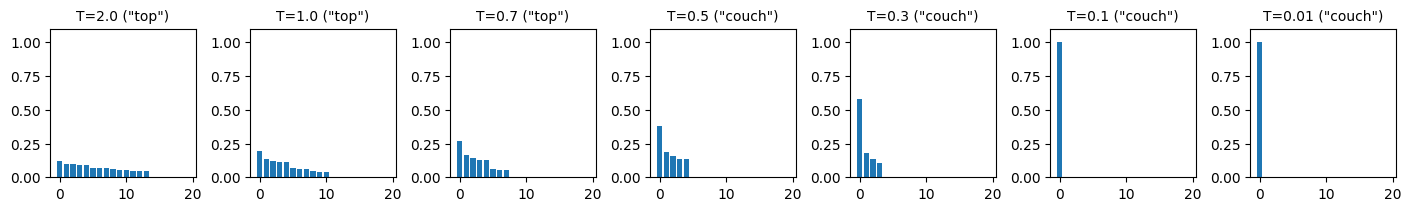

In [42]:
from matplotlib import pyplot as plt
import torch.nn.functional as F
softmax = F.softmax

top_k = 20
temperatures = [2.0, 1.0, 0.7, 0.5, 0.3, 0.1, 0.01]

# creaate subfigure
fig, axes = plt.subplots(1, len(temperatures), layout='constrained', figsize=(len(temperatures)*2, 2))

for ax, temp in zip(axes, temperatures):
    set_seed(42)
    outputs = model.generate(**inputs, max_new_tokens=1, temperature=temp, output_scores=True, return_dict_in_generate=True)
    next_token = tokenizer.decode(outputs.sequences[0].detach().cpu(), skip_special_tokens=True).split()[-1]
    logits = outputs.scores[0].detach().cpu()
    probs = softmax(logits[0], dim=-1)
    top_k_idxs = probs.argsort(descending=True)[:top_k]
    top_k_probs = probs[top_k_idxs]
    top_k_tokens = tokenizer.convert_ids_to_tokens(top_k_idxs)
    #plt.plot(top_k_probs.tolist(), label=f"T={temp}", marker='.', markersize=3, alpha=0.7)
    #plt.figure(figsize=(2,2))
    ax.bar(range(top_k), top_k_probs.tolist())
    ax.set_title(f'T={temp} ("{next_token}")', fontsize=10)
    ax.set_ylim(0, 1.1)

### **Top-K Sampling**

[Fan et. al (2018)](https://arxiv.org/pdf/1805.04833.pdf) introduced a simple, but very powerful sampling scheme, called ***Top-K*** sampling. In *Top-K* sampling, the *K* most likely next words are filtered and the probability mass is redistributed among only those *K* next words. 
GPT2 adopted this sampling scheme, which was one of the reasons for its success in story generation. 

We extend the range of words used for both sampling steps in the example above from 3 words to 10 words to better illustrate *Top-K* sampling.

![top_k_sampling](https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/top_k_sampling.png){width="50%"}

Having set $K = 6$, in both sampling steps we limit our sampling pool to 6 words. While the 6 most likely words, defined as $V_{\text{top-K}}$ encompass only *ca.* two-thirds of the whole probability mass in the first step, it includes almost all of the probability mass in the second step. Nevertheless, we see that it successfully eliminates the rather weird candidates $\text{"not", "the", "small", "told"}$ 
in the second sampling step.


Let's see how *Top-K* can be used in the library by setting `top_k=50`:

In [44]:
# encode context the generation is conditioned on
input_ids = tokenizer.encode('I enjoy walking with my cute dog', return_tensors='pt')

# set seed to reproduce results. Feel free to change the seed though to get different results
# set top_k to 50
set_seed(42)
sample_output = model.generate(
    input_ids.to(model.device),
    do_sample=True, 
    max_length=50, 
    top_k=50
)

print(tokenizer.decode(sample_output[0].detach().cpu(), skip_special_tokens=True))

I enjoy walking with my cute dog. In one day, I walk to the park and back home in 3 hours. The distance from my house to the park is 2 miles. What is the average speed of my dog if it takes me


Not bad at all! The text is arguably the most *human-sounding* text so far. 
One concern though with *Top-K* sampling is that it does not dynamically adapt the number of words that are filtered from the next word probability distribution $P(w|w_{1:t-1})$.
This can be problematic as some words might be sampled from a very sharp distribution (distribution on the right in the graph above), whereas others from a much more flat distribution (distribution on the left in the graph above). 

In step $t=1$, *Top-K* eliminates the possibility to 
sample $\text{"people", "big", "house", "cat"}$, which seem like reasonable candidates. On the other hand, in step $t=2$ the method includes the arguably ill-fitted words $\text{"down", "a"}$ in the sample pool of words. Thus, limiting the sample pool to a fixed size *K* could endanger the model to produce gibberish for sharp distributions and limit the model's creativity for flat distribution.
This intuition led [Ari Holtzman et al. (2019)](https://arxiv.org/abs/1904.09751) to create ***Top-p***- or ***nucleus***-sampling. 



### **Top-p (nucleus) sampling**

Instead of sampling only from the most likely *K* words, in *Top-p* sampling chooses from the smallest possible set of words whose cumulative probability exceeds the probability *p*. The probability mass is then redistributed among this set of words. This way, the size of the set of words (*a.k.a* the number of words in the set) can dynamically increase and decrease according to the next word's probability distribution. Ok, that was very wordy, let's visualize.

![top_p_sampling](https://github.com/patrickvonplaten/scientific_images/blob/master/top_p_sampling.png?raw=true){width="50%"}

Having set $p=0.92$, *Top-p* sampling picks the *minimum* number of words to exceed together $p=92\%$ of the probability mass, defined as $V_{\text{top-p}}$. In the first example, this included the 9 most likely words, whereas it only has to pick the top 3 words in the second example to exceed 92%. Quite simple actually! It can be seen that it keeps a wide range of words where the next word is arguably less predictable, *e.g.* $P(w | \text{"The"})$, and only a few words when the next word seems more predictable, *e.g.* $P(w | \text{"The", "car"})$.

Alright, time to check it out in `transformers`!
We activate *Top-p* sampling by setting `0 < top_p < 1`:

In [45]:
# deactivate top_k sampling and sample only from 92% most likely words
set_seed(42)
sample_output = model.generate(
    input_ids.to(model.device),
    do_sample=True,
    max_length=50,
    top_p=0.92,
    top_k=0
)

print(tokenizer.decode(sample_output[0].detach().cpu(), skip_special_tokens=True))

I enjoy walking with my cute dog. In one day, I walk to work and back home, which is a total of 3 miles each way. Additionally, I take the bus that takes me from home to work and back home, which is


Great, that sounds like it could have been written by a human. Well, maybe not quite yet. 

While in theory, *Top-p* seems more elegant than *Top-K*, both methods work  well in practice. *Top-p* can also be used in combination with *Top-K*, which can avoid very low ranked words while allowing for some dynamic selection.

Finally, to get multiple independently sampled outputs, we can *again* set the parameter `num_return_sequences > 1`: 

In [46]:
# set top_k = 50 and set top_p = 0.95 and num_return_sequences = 3
set_seed(42)
sample_outputs = model.generate(
    input_ids.to(model.device),
    do_sample=True, 
    max_length=50, 
    top_k=50, 
    top_p=0.95, 
    num_return_sequences=3
)

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}".format(i, tokenizer.decode(sample_output.detach().cpu(), skip_special_tokens=True)))

0: I enjoy walking with my cute dog. In one day, I walk to work and back home, which is a total of 3 miles each way. Additionally, I take the bus that takes me from home to work and back home, which is
1: I enjoy walking with my cute dog, which is a lot of fun. Here's a question about the following context:  
[The book "A Brief History of Time" by Stephen Hawking]. In the second chapter, Hawking mentions an old
2: I enjoy walking with my cute dog, but I also have a very annoying cat. Whenever the cat is near, I can't help but feel annoyed and frustrated, which causes me to always be on the lookout for that cat. Is there any way


Cool, now you should have all the tools to let your model write your stories with `transformers`!

### **Conclusion**

As *ad-hoc* decoding methods, *top-p* and *top-K* sampling seem to produce more fluent text than traditional *greedy* - and *beam* search on open-ended language generation. 
Recently, there has been more evidence though that the apparent flaws of *greedy* and *beam* search - mainly generating repetitive word sequences - are  caused by the model (especially the way the model is trained), rather than the decoding method, *cf.* [Welleck et al. (2019)](https://arxiv.org/pdf/1908.04319.pdf). Also, as demonstrated in [Welleck et al. (2020)](https://arxiv.org/abs/2002.02492), it looks as *top-K* and *top-p* sampling also suffer from generating repetitive word sequences.

In [Welleck et al. (2019)](https://arxiv.org/pdf/1908.04319.pdf), the authors show that according to human evaluations, *beam* search can generate more fluent text than *Top-p* sampling, when adapting the model's training objective.

Open-ended language generation is a rapidly evolving field of research and as it is often the case there is no one-size-fits-all method here, so one has to see what works best in one's specific use case.

Good thing, that *you* can try out all the different decoding methods in `transfomers` 🤗. 

That was a short introduction on how to use different decoding methods in `transformers` and recent trends in open-ended language generation. 

Feedback and questions are very welcome on the [Github repository](https://github.com/huggingface/transformers).

For more fun generating stories, please take a look at [Writing with Transformers](https://transformer.huggingface.co).

Thanks to everybody, who has contributed to the blog post: Alexander Rush, Julien Chaumand, Thomas Wolf, Victor Sanh, Sam Shleifer, Clément Delangue, Yacine Jernite, Oliver Åstrand and John de Wasseige.


### **Appendix**

There are a couple of additional parameters for the `generate` method that were not mentioned above. We will explain them here briefly!

- `min_length` can be used to force the model to not produce an EOS token (= not finish the sentence) before `min_length` is reached. This is used quite frequently in summarization, but can be useful in general if the user wants to have longer outputs.
- `repetition_penalty` can be used to penalize words that were already generated or belong to the context. It was first introduced by [Kesker et al. (2019)](https://arxiv.org/abs/1909.05858) and is also used in the training objective in [Welleck et al. (2019)](https://arxiv.org/pdf/1908.04319.pdf). It can be quite effective at preventing repetitions, but seems to be very sensitive to different models and use cases, *e.g.* see this [discussion](https://github.com/huggingface/transformers/pull/2303) on Github.

- `attention_mask` can be used to mask padded tokens
- `pad_token_id`, `bos_token_id`, `eos_token_id`: If the model does not have those tokens by default, the user can manually choose other token ids to represent them.

For more information please also look into the `generate` function [docstring](https://huggingface.co/transformers/main_classes/model.html?highlight=generate#transformers.TFPreTrainedModel.generate).